In [1]:
import pickle
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import numpy as np

nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aligo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aligo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
brands = [
  "latvenergo",
  "rimi",
  "maxima",
  "swedbank",
  "lmt",
  "tet",
  "lg",
  "tele2",
  "airbaltic",
  "olympic",
  "seb",
  "grindeks",
  "citadele",
  "bite",
  "drogas",
  "depo",
  "circlek",
  "lb",
  "optibet",
  "evolution",
];

In [36]:
def readCsv(brand):
    tweets = pd.read_csv('./tweets/raw/'+brand+'.csv')
    tweets['brand'] = brand
#     tweets = tweets[tweets['label'].notna()]
    tweets['message'] = tweets['message'].astype(str)
    return tweets

In [37]:
latvenergoTweets = readCsv("latvenergo")
len(latvenergoTweets)

1079

In [38]:
latvenergoTweets.head()

,message,id,tweetId,createdAt,language,inReplyToStatusId,inReplyToUserId,inReplyToScreenName,userId,userName,...,placeFullName,placeType,retweetedId,monitoringObjectId1,monitoringObjectId2,queryId,sentiment,retweetCount,label,brand
0,. @Latvenergo sola iespējami drīz sludināt kon...,1485989,925773904852942800,2017-11-01T19:17:53,lv,NaN,NaN,NaN,171409557,LSM ziņu portāls,...,NaN,NaN,NaN,671,671,910.0,NaN,0,0.0,latvenergo
1,"Zivs pūst no galvas, @Latvenergo - no sadales ...",1488724,925747124788133900,2017-11-01T17:31:28,lv,NaN,NaN,NaN,2447289726,šķirsts,...,NaN,NaN,NaN,191,191,430.0,NaN,0,0.0,latvenergo
2,Piemēram @Lattelecom pat spamot māk. Bet @man...,1488775,925824684683419600,2017-11-01T22:39:40,lv,NaN,NaN,NaN,935190734,Janis Liberts,...,NaN,NaN,NaN,184,184,423.0,NaN,0,2.0,latvenergo
3,Notice on Noteholders’ Meetings to all Notehol...,1495982,926088293204324400,2017-11-02T16:07:09,en,NaN,NaN,NaN,438816954,GNWLive,...,NaN,NaN,NaN,191,191,384.0,NaN,0,NaN,latvenergo
4,По сравнению с аферой по закупке зелёной энерг...,1498011,926125087920672800,2017-11-02T18:33:22,ru,NaN,NaN,NaN,158284998,Sergey Potapkin,...,NaN,NaN,NaN,191,191,384.0,NaN,0,NaN,latvenergo


In [39]:
def clean_tweets(data):
#     lowercase posts and clean data with regexs
    posessivePronouns = "'s"
    newLine ="\\n"
    urls = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
    numbers = ' \d+((\.|\-)\d+)? '
    mentions = '\B\@([\w\-]+)'
    hashtag = '#'
    punctuationAfterWord = '(?<=\s)|(?<=^)|(?<=\b)(?:[-\'.%$#&,\/:!-?`“–&]\b|\b[-\'.%$#&,\/:!-?`“–&])+(?=\s|$|\b)'
    punctuation = '[(,|.|!|\-|\–|\`|?|:|“|”|►|;|\'|%|&|@)]?'
    smile = ':\)|=\)'
    frown = ':\(|=\('
    whitespacesOrSlash = '\s+|\/'
    leadTrailWhitespace = '^\s+|\s+?$'

    data['clean_message'] = data['message'].str.lower()
    data['clean_message'] = data['clean_message'].str.replace(posessivePronouns,'',regex=True)
    data['clean_message'] = data['clean_message'].str.replace(newLine,'',regex=True)
    data['clean_message'] = data['clean_message'].str.replace(urls,' URL ',regex=True)
    data['clean_message'] = data['clean_message'].str.replace(mentions,' MENTION ',regex=True)
    data['clean_message'] = data['clean_message'].str.replace(punctuation,'',regex=True)
    data['clean_message'] = data['clean_message'].str.replace(numbers,' NMBR ',regex=True)
    data['clean_message'] = data['clean_message'].str.replace(hashtag,'',regex=True)
    data['clean_message'] = data['clean_message'].str.replace(smile,'SMILE',regex=True)
    data['clean_message'] = data['clean_message'].str.replace(frown,'FROWN',regex=True)
    data['clean_message'] = data['clean_message'].str.replace(punctuationAfterWord,'',regex=True)
    data['clean_message'] = data['clean_message'].str.replace(whitespacesOrSlash,' ',regex=True)
    data['clean_message'] = data['clean_message'].str.replace(leadTrailWhitespace,'',regex=True)
    
#     tokenize and remove stopwords
    stopwords_lv = ["ārpus", "šaipus", "aiz", "ap", "apakš", "apakšpus", "arī", "ar", "ar", "augšpus", "būšu", "būs", "būsi", "būsiet", "būsim", "būt", "bet", "bez", "bijām", "bijāt", "bija", "biji", "biju", "caur", "dēļ", "diemžēl", "diezin", "droši", "esam", "esat", "esi", "esmu", "gan", "gar", "iekām", "iekāms", "iekš", "iekšpus", "iekam", "iekams", "ik", "ir", "it", "itin", "iz", "jā", "ja", "jau", "jebšu", "jeb", "jel", "jo", "kā", "kļūšu", "kļūs", "kļūsi", "kļūsiet", "kļūsim", "kļūst", "kļūstam	kļūstat", "kļūsti", "kļūstu", "kļūt", "kļuvām", "kļuvāt", "kļuva", "kļuvi", "kļuvu", "ka", "kamēr", "kaut", "kolīdz", "kopš", "līdz", "līdzko", "labad", "lai", "lejpus", "nē", "ne", "nebūt", "nedz", "nekā", "nevis", "nezin", "no", "nu", "otrpus", "pār", "pēc", "pa", "par", "pat", "pie", "pirms", "pret", "priekš", "starp", "tā", "tādēļ", "tālab", "tāpēc", "taču", "tad", "tak", "tapāt", "tapšu", "tapi", "taps", "tapsi", "tapsiet", "tapsim", "tapt", "te", "tiec", "tiek", "tiekam", "tiekat", "tieku	tikām", "tikāt", "tikšu", "tik", "tika", "tikai", "tiki", "tikko", "tiklīdz", "tiklab", "tiks", "tiksiet", "tiksim", "tikt", "tiku", "tikvien", "tomēr", "topat", "turpretī", "turpretim", "un", "uz", "vai", "varēšu", "varējām", "varējāt", "varēja", "varēji", "varēju", "varēs", "varēsi", "varēsiet", "varēsim", "varēt", "var", "varat", "viņpus", "vien", "vien", "virs", "virspus", "vis", "zem"]
    message_no_stopwords=[]

    for message in data.clean_message:
        text_tokens = word_tokenize(message)
        tokens_without_stop_words = [word for word in text_tokens if not word in stopwords_lv]
        message_no_stopwords.append((" ").join(tokens_without_stop_words))

    data['message_no_stopwords'] = message_no_stopwords
    return data

In [40]:
latvenergoTweets = clean_tweets(latvenergoTweets)
latvenergoTweets.head()

,message,id,tweetId,createdAt,language,inReplyToStatusId,inReplyToUserId,inReplyToScreenName,userId,userName,...,retweetedId,monitoringObjectId1,monitoringObjectId2,queryId,sentiment,retweetCount,label,brand,clean_message,message_no_stopwords
0,. @Latvenergo sola iespējami drīz sludināt kon...,1485989,925773904852942800,2017-11-01T19:17:53,lv,NaN,NaN,NaN,171409557,LSM ziņu portāls,...,NaN,671,671,910.0,NaN,0,0.0,latvenergo,MENTION sola iespējami drīz sludināt konkursu ...,MENTION sola iespējami drīz sludināt konkursu ...
1,"Zivs pūst no galvas, @Latvenergo - no sadales ...",1488724,925747124788133900,2017-11-01T17:31:28,lv,NaN,NaN,NaN,2447289726,šķirsts,...,NaN,191,191,430.0,NaN,0,0.0,latvenergo,zivs pūst no galvas MENTION no sadales kārbas URL,zivs pūst galvas MENTION sadales kārbas URL
2,Piemēram @Lattelecom pat spamot māk. Bet @man...,1488775,925824684683419600,2017-11-01T22:39:40,lv,NaN,NaN,NaN,935190734,Janis Liberts,...,NaN,184,184,423.0,NaN,0,2.0,latvenergo,piemēram MENTION pat spamot māk bet MENTION ne...,piemēram MENTION spamot māk MENTION nemāk rēķi...
3,Notice on Noteholders’ Meetings to all Notehol...,1495982,926088293204324400,2017-11-02T16:07:09,en,NaN,NaN,NaN,438816954,GNWLive,...,NaN,191,191,384.0,NaN,0,NaN,latvenergo,notice on noteholders’ meetings to all notehol...,notice on noteholders ’ meetings to all noteho...
4,По сравнению с аферой по закупке зелёной энерг...,1498011,926125087920672800,2017-11-02T18:33:22,ru,NaN,NaN,NaN,158284998,Sergey Potapkin,...,NaN,191,191,384.0,NaN,0,NaN,latvenergo,по сравнению с аферой по закупке зелёной энерг...,по сравнению с аферой по закупке зелёной энерг...


In [41]:
def find_features_no_brands(clean_tweet):
    words = word_tokenize(clean_tweet)
    features = {}
    
    #read generated features with no brand names
    with open('./data/wordFeaturesWithoutBrands.data', 'rb') as filehandle:
        # read the data as binary data stream
        word_features = pickle.load(filehandle)
    
    for word in word_features:
        features[word] = (word in words)
    return features

In [42]:
def classifyTweet_NB(clean_tweet):
    modelFile = './nb/nb_tweet_classifier.sav'
    
    loaded_model = pickle.load(open(modelFile, 'rb'))
    
    featureset = find_features_no_brands(clean_tweet)
    
    result = loaded_model.classify(featureset)
        
    return result

In [46]:
# for index, row in latvenergoTweets.iterrows():
#     latvenergoTweets[index]["NB_label"] = classifyTweet_NB(row["message_no_stopwords"])
    
# latvenergoTweets['NB_label'] = classifyTweet_NB(latvenergoTweets['message_no_stopwords'])
# latvenergoTweets.head()

print(classifyTweet_NB(latvenergoTweets.loc[42]['message_no_stopwords']), latvenergoTweets.loc[42]['label'])

0 nan


In [58]:
NBlabels = []
for index, row in latvenergoTweets.iterrows():
    if(np.isnan(row["label"])):
        NBlabels.append(classifyTweet_NB(row["message_no_stopwords"]))
    else:
        NBlabels.append(int(row["label"]))

latvenergoTweets["NB_label"] = NBlabels
latvenergoTweets.head()

,message,id,tweetId,createdAt,language,inReplyToStatusId,inReplyToUserId,inReplyToScreenName,userId,userName,...,monitoringObjectId1,monitoringObjectId2,queryId,sentiment,retweetCount,label,brand,clean_message,message_no_stopwords,NB_label
0,. @Latvenergo sola iespējami drīz sludināt kon...,1485989,925773904852942800,2017-11-01T19:17:53,lv,NaN,NaN,NaN,171409557,LSM ziņu portāls,...,671,671,910.0,NaN,0,0.0,latvenergo,MENTION sola iespējami drīz sludināt konkursu ...,MENTION sola iespējami drīz sludināt konkursu ...,0
1,"Zivs pūst no galvas, @Latvenergo - no sadales ...",1488724,925747124788133900,2017-11-01T17:31:28,lv,NaN,NaN,NaN,2447289726,šķirsts,...,191,191,430.0,NaN,0,0.0,latvenergo,zivs pūst no galvas MENTION no sadales kārbas URL,zivs pūst galvas MENTION sadales kārbas URL,0
2,Piemēram @Lattelecom pat spamot māk. Bet @man...,1488775,925824684683419600,2017-11-01T22:39:40,lv,NaN,NaN,NaN,935190734,Janis Liberts,...,184,184,423.0,NaN,0,2.0,latvenergo,piemēram MENTION pat spamot māk bet MENTION ne...,piemēram MENTION spamot māk MENTION nemāk rēķi...,2
3,Notice on Noteholders’ Meetings to all Notehol...,1495982,926088293204324400,2017-11-02T16:07:09,en,NaN,NaN,NaN,438816954,GNWLive,...,191,191,384.0,NaN,0,NaN,latvenergo,notice on noteholders’ meetings to all notehol...,notice on noteholders ’ meetings to all noteho...,0
4,По сравнению с аферой по закупке зелёной энерг...,1498011,926125087920672800,2017-11-02T18:33:22,ru,NaN,NaN,NaN,158284998,Sergey Potapkin,...,191,191,384.0,NaN,0,NaN,latvenergo,по сравнению с аферой по закупке зелёной энерг...,по сравнению с аферой по закупке зелёной энерг...,0


In [59]:
latvenergoTweets["NB_label"].value_counts()

0    970
2     93
1     16
Name: NB_label, dtype: int64

In [60]:
latvenergoTweets["label"].value_counts()

0.0    38
2.0    28
1.0    16
Name: label, dtype: int64

In [75]:
import datetime
datetime_object = datetime.datetime.strptime(latvenergoTweets.loc[42]['createdAt'], '%Y-%m-%dT%H:%M:%S').strftime('%Y,%m,%d')

print(datetime_object)

2017,11,21


In [76]:
latvenergoTweets['createdAt']

0             2017-11-01T19:17:53
1             2017-11-01T17:31:28
2             2017-11-01T22:39:40
3             2017-11-02T16:07:09
4             2017-11-02T18:33:22
                  ...            
1074    2021-04-15T06:33:41+00:00
1075    2021-04-15T15:45:09+00:00
1076    2021-04-19T10:54:13+00:00
1077    2021-04-20T06:54:59+00:00
1078    2021-04-23T10:43:54+00:00
Name: createdAt, Length: 1079, dtype: object

In [86]:
print(latvenergoTweets.loc[1078]['createdAt'])

print(latvenergoTweets.loc[1078]['createdAt'].replace('+00:00',''))

2021-04-23T10:43:54+00:00
2021-04-23T10:43:54


In [96]:
dates_no_0 = []
for index, row in latvenergoTweets.iterrows():
    dates_no_0.append(row['createdAt'].replace('+00:00',''))

latvenergoTweets["date_no_0"] = dates_no_0

latvenergoTweets['date_no_0']

0       2017-11-01T19:17:53
1       2017-11-01T17:31:28
2       2017-11-01T22:39:40
3       2017-11-02T16:07:09
4       2017-11-02T18:33:22
               ...         
1074    2021-04-15T06:33:41
1075    2021-04-15T15:45:09
1076    2021-04-19T10:54:13
1077    2021-04-20T06:54:59
1078    2021-04-23T10:43:54
Name: date_no_0, Length: 1079, dtype: object

In [108]:
dates = []
for index, row in latvenergoTweets.iterrows():
    dates.append(datetime.strptime(row['date_no_0'], '%Y-%m-%dT%H:%M:%S').strftime('%Y,%m,%d'))

latvenergoTweets["date"] = dates
latvenergoTweets.head()

,message,id,tweetId,createdAt,language,inReplyToStatusId,inReplyToUserId,inReplyToScreenName,userId,userName,...,queryId,sentiment,retweetCount,label,brand,clean_message,message_no_stopwords,NB_label,date_no_0,date
0,. @Latvenergo sola iespējami drīz sludināt kon...,1485989,925773904852942800,2017-11-01T19:17:53,lv,NaN,NaN,NaN,171409557,LSM ziņu portāls,...,910.0,NaN,0,0.0,latvenergo,MENTION sola iespējami drīz sludināt konkursu ...,MENTION sola iespējami drīz sludināt konkursu ...,0,2017-11-01T19:17:53,"2017,11,01"
1,"Zivs pūst no galvas, @Latvenergo - no sadales ...",1488724,925747124788133900,2017-11-01T17:31:28,lv,NaN,NaN,NaN,2447289726,šķirsts,...,430.0,NaN,0,0.0,latvenergo,zivs pūst no galvas MENTION no sadales kārbas URL,zivs pūst galvas MENTION sadales kārbas URL,0,2017-11-01T17:31:28,"2017,11,01"
2,Piemēram @Lattelecom pat spamot māk. Bet @man...,1488775,925824684683419600,2017-11-01T22:39:40,lv,NaN,NaN,NaN,935190734,Janis Liberts,...,423.0,NaN,0,2.0,latvenergo,piemēram MENTION pat spamot māk bet MENTION ne...,piemēram MENTION spamot māk MENTION nemāk rēķi...,2,2017-11-01T22:39:40,"2017,11,01"
3,Notice on Noteholders’ Meetings to all Notehol...,1495982,926088293204324400,2017-11-02T16:07:09,en,NaN,NaN,NaN,438816954,GNWLive,...,384.0,NaN,0,NaN,latvenergo,notice on noteholders’ meetings to all notehol...,notice on noteholders ’ meetings to all noteho...,0,2017-11-02T16:07:09,"2017,11,02"
4,По сравнению с аферой по закупке зелёной энерг...,1498011,926125087920672800,2017-11-02T18:33:22,ru,NaN,NaN,NaN,158284998,Sergey Potapkin,...,384.0,NaN,0,NaN,latvenergo,по сравнению с аферой по закупке зелёной энерг...,по сравнению с аферой по закупке зелёной энерг...,0,2017-11-02T18:33:22,"2017,11,02"


In [111]:
print(latvenergoTweets["date"].tolist()[:7])

['2017,11,01', '2017,11,01', '2017,11,01', '2017,11,02', '2017,11,02', '2017,11,03', '2017,11,06']


In [124]:
class dateSentimentValues: 
    def __init__(self, date, tweetCount, neutralCount, positiveCount, negativeCount): 
        self.date = date 
        self.tweetCount = tweetCount
        self.neutralCount = neutralCount
        self.positiveCount = positiveCount
        self.negativeCount = negativeCount

In [140]:
sentimentList = []

for index, row in latvenergoTweets.iterrows():
    existingDate = 0
    if (len(sentimentList)==0):
        if(row['NB_label']==0):
            sentimentList.append(dateSentimentValues(row['date'], (1 + row['retweetCount']), (1 + row['retweetCount']), 0, 0))
        elif(row['NB_label']==1):
            sentimentList.append(dateSentimentValues(row['date'], (1 + row['retweetCount']), 0, (1 + row['retweetCount']), 0))
        elif(row['NB_label']==2):
            sentimentList.append(dateSentimentValues(row['date'], (1 + row['retweetCount']), 0, 0, (1 + row['retweetCount'])))
    else:
        for item in sentimentList:
            if(item.date == row['date']):
                existingDate = 1
                item.tweetCount += (1 + row['retweetCount'])
                if(row['NB_label']==0):
                    item.neutralCount+=1
                elif(row['NB_label']==1):
                    item.positiveCount+=1
                elif(row['NB_label']==2):
                    item.negativeCount+=1
                break
        if(existingDate==0):
            if(row['NB_label']==0):
                sentimentList.append(dateSentimentValues(row['date'], (1 + row['retweetCount']), (1 + row['retweetCount']), 0, 0))
            elif(row['NB_label']==1):
                sentimentList.append(dateSentimentValues(row['date'], (1 + row['retweetCount']), 0, (1 + row['retweetCount']), 0))
            elif(row['NB_label']==2):
                sentimentList.append(dateSentimentValues(row['date'], (1 + row['retweetCount']), 0, 0, (1 + row['retweetCount'])))
            
print(sentimentList[:5])

[<__main__.dateSentimentValues object at 0x000001BAAA05ED90>, <__main__.dateSentimentValues object at 0x000001BAABC06250>, <__main__.dateSentimentValues object at 0x000001BAAA05EFD0>, <__main__.dateSentimentValues object at 0x000001BAAA05EF10>, <__main__.dateSentimentValues object at 0x000001BAAA05E8E0>]


In [142]:
for item in sentimentList:
    print(item.date, item.tweetCount)

2017,11,01 3
2017,11,02 2
2017,11,03 1
2017,11,06 14
2017,11,08 38
2017,11,09 5
2017,11,10 1
2017,11,11 2
2017,11,12 2
2017,11,13 3
2017,11,15 53
2017,11,16 2
2017,11,17 1
2017,11,20 1
2017,11,21 26
2017,11,22 2
2017,11,23 3
2017,11,24 1
2017,11,29 2
2017,11,30 20
2017,12,02 1
2017,12,04 46
2017,12,05 7
2017,12,06 2
2017,12,12 1
2017,12,13 2
2017,12,14 11
2017,12,15 5
2017,12,23 1
2017,12,24 1
2017,12,26 1
2018,04,24 2
2018,05,07 1
2018,04,19 2
2018,04,25 2
2018,04,20 1
2018,05,26 2
2018,05,16 3
2018,05,28 1
2018,05,24 7
2018,05,23 3
2018,05,19 54
2018,05,18 19
2018,05,10 3
2018,05,09 1
2018,05,13 1
2018,05,31 4
2018,06,03 1
2018,06,04 2
2018,06,07 2
2018,06,08 6
2018,06,11 7
2018,06,13 1
2018,06,15 10
2018,06,16 1
2018,06,18 17
2018,06,19 7
2018,06,20 9
2018,06,21 2
2018,06,22 4
2018,06,25 1
2018,06,27 3
2018,06,28 3
2018,06,30 24
2018,07,06 4
2018,07,09 61
2018,07,10 1
2018,07,18 28
2018,07,25 3
2018,07,27 13
2018,07,30 1
2018,08,07 1
2018,08,08 6
2018,08,09 1
2018,08,14 2
2018,08,15

In [282]:
dates = []
tweetCounts=[]
neutralCounts = []
positiveCounts=[]
negativeCounts =[]

for item in sentimentList:
    dates.append(item.date)
    tweetCounts.append(item.tweetCount)
    neutralCounts.append(item.neutralCount)
    positiveCounts.append(item.positiveCount) 
    negativeCounts.append(item.negativeCount)

In [283]:
negativeCounts

[1,
 0,
 1,
 14,
 2,
 0,
 1,
 0,
 0,
 0,
 49,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 46,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 3,
 1,
 0,
 1,
 1,
 19,
 3,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 16,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 63,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 5,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 3,
 2,
 2,
 0,
 0,
 5,
 0,
 1,
 2,
 0,
 0,
 3,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0

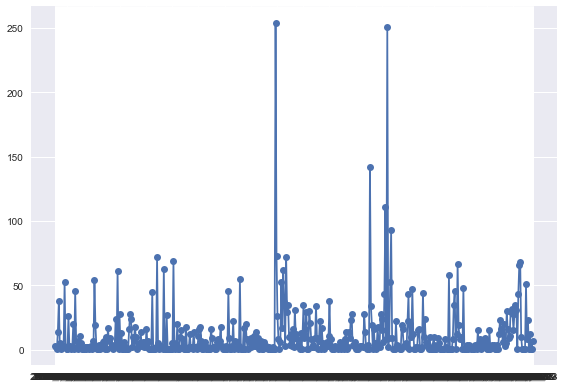

In [148]:
# plot_time_series.py

import matplotlib.pyplot as plt
from datetime import datetime, timedelta
plt.style.use('seaborn')

dates = dates

y = tweetCounts

plt.plot_date(dates, y, linestyle ='solid')
plt.tight_layout()
plt.show()

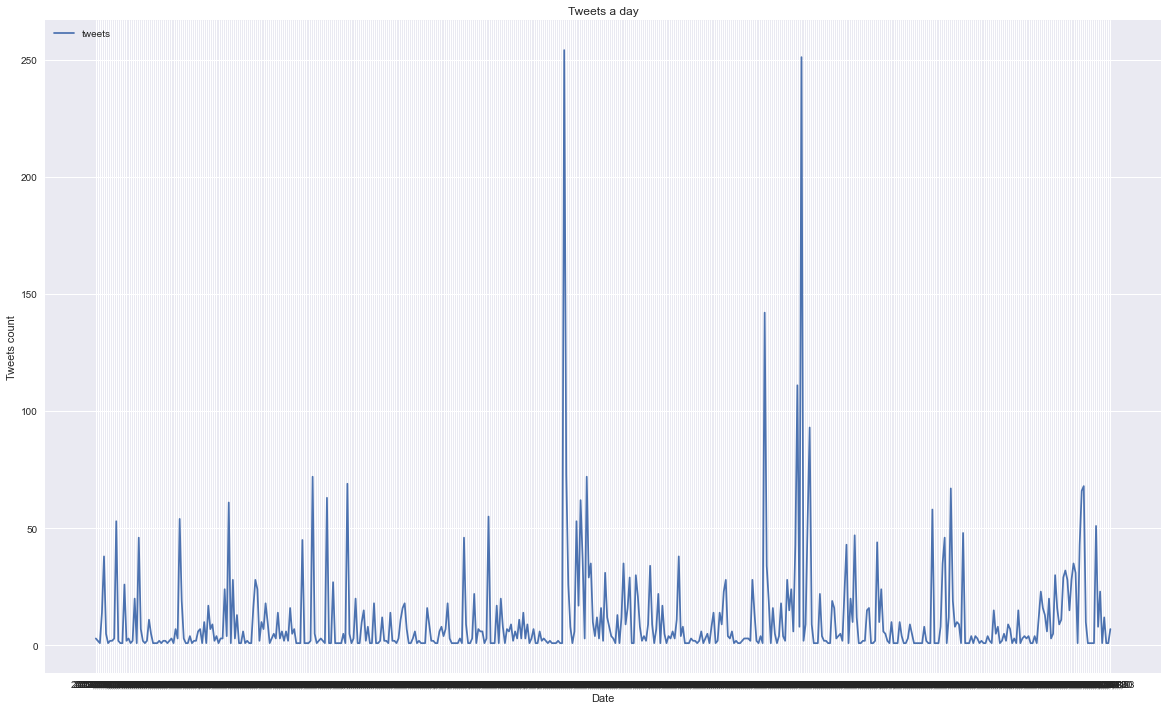

In [154]:
plt.rc('font', size=5)
fig, ax = plt.subplots(figsize=(20, 12))

# Specify how our lines should look
ax.plot(dates, tweetCounts, label='tweets')

ax.set_xlabel('Date')
ax.set_ylabel('Tweets count')
ax.set_title('Tweets a day')
ax.grid(True)
ax.legend(loc='upper left');

In [245]:
from datetime import datetime, timedelta

# d= datetime.strptime(startDate, '%Y,%m,%d').date()
d="2020,12,12".split(",")

date = datetime(int(d[0]),int(d[1]),int(d[2]))
for i in range(5): 
    date += timedelta(days=1)
    print(date.date()) 
    
print((date).strftime('%Y,%m,%d'))

2020-12-13
2020-12-14
2020-12-15
2020-12-16
2020-12-17
2020,12,17


In [269]:
date = "2020,01,01"
print(findClosestDate(date))

315


In [268]:
def findClosestDate(date):
    dateArr = date.split(",")
    d = datetime(int(dateArr[0]),int(dateArr[1]),int(dateArr[2])) #separated by -
    while(d.strftime('%Y,%m,%d') not in dates):
        d += timedelta(days=1)

    return dates.index(d.strftime('%Y,%m,%d'))

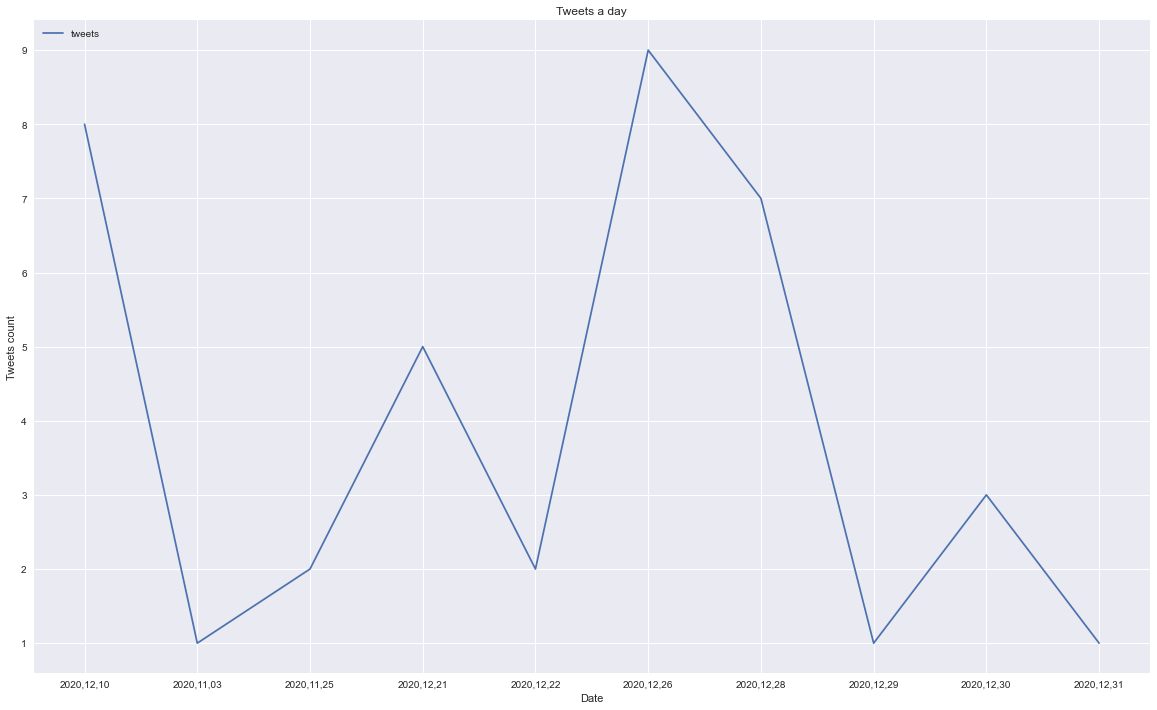

In [272]:
startDate = "2020,12,01"
endDate = "2021,01,01"

startIndex= findClosestDate(startDate)
endIndex= findClosestDate(endDate)
    
plt.rc('font', size=1)
fig, ax = plt.subplots(figsize=(20, 12))

# Specify how our lines should look
ax.plot(dates[startIndex:endIndex], tweetCounts[startIndex:endIndex], label='tweets')

ax.set_xlabel('Date')
ax.set_ylabel('Tweets count')
ax.set_title('Tweets a day')
ax.grid(True)
ax.legend(loc='upper left');

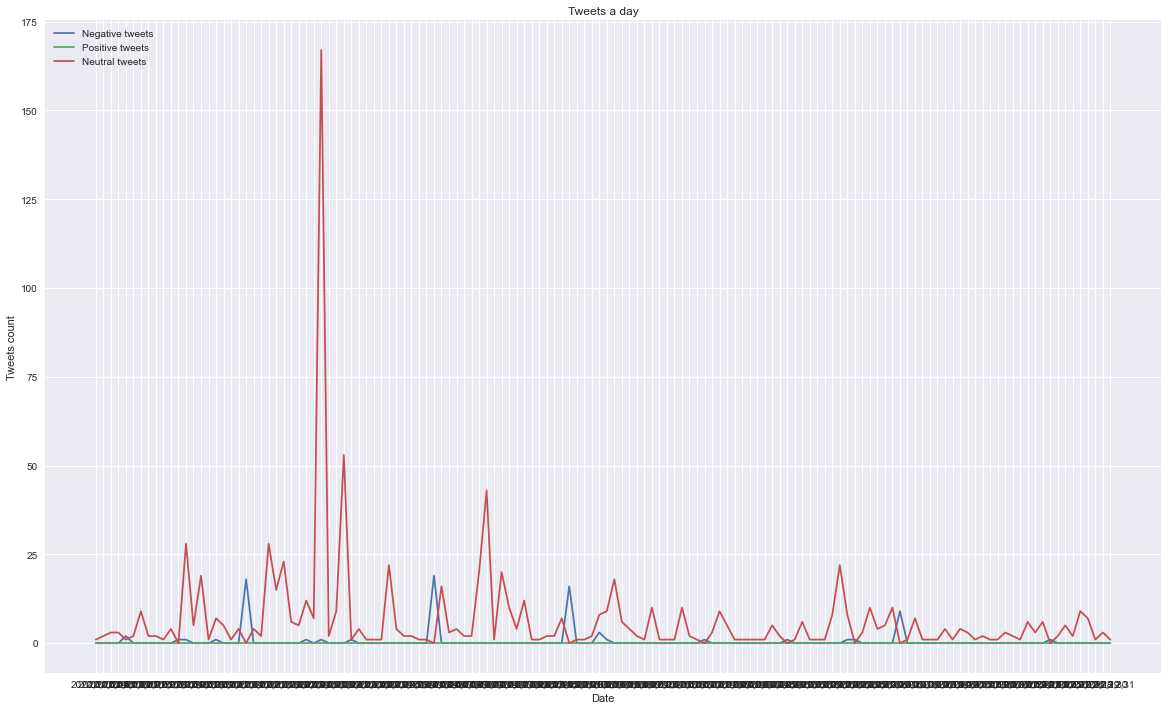

In [290]:
startDate = "2020,01,01"
endDate = "2021,01,01"

startIndex= findClosestDate(startDate)
endIndex= findClosestDate(endDate)
    
plt.rc('font', size=1)
fig, ax = plt.subplots(figsize=(20, 12))

# Specify how our lines should look
ax.plot(dates[startIndex:endIndex], negativeCounts[startIndex:endIndex], label='Negative tweets')
ax.plot(dates[startIndex:endIndex], positiveCounts[startIndex:endIndex], label='Positive tweets')
ax.plot(dates[startIndex:endIndex], neutralCounts[startIndex:endIndex], label='Neutral tweets')

ax.set_xlabel('Date')
ax.set_ylabel('Tweets count')
ax.set_title('Tweets a day')
ax.grid(True)
ax.legend(loc='upper left');

In [289]:
sentimentCounts = []
for date in dates:
    i = dates.index(date)
    sentiment = positiveCounts[i] - negativeCounts[i]
    sentimentCounts.append(sentiment)
    
sentimentCounts

[-1,
 0,
 -1,
 -14,
 -2,
 0,
 -1,
 0,
 0,
 1,
 -49,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 -46,
 0,
 0,
 0,
 0,
 11,
 1,
 -1,
 1,
 0,
 2,
 0,
 0,
 0,
 -1,
 -1,
 -3,
 -1,
 0,
 -1,
 -1,
 -19,
 -3,
 -1,
 -1,
 1,
 -1,
 2,
 0,
 0,
 5,
 1,
 2,
 0,
 1,
 1,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 -16,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 -1,
 -63,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 -5,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -4,
 0,
 -1,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 -6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 -3,
 -2,
 -2,
 0,
 0,
 -5,
 0,
 -1,
 

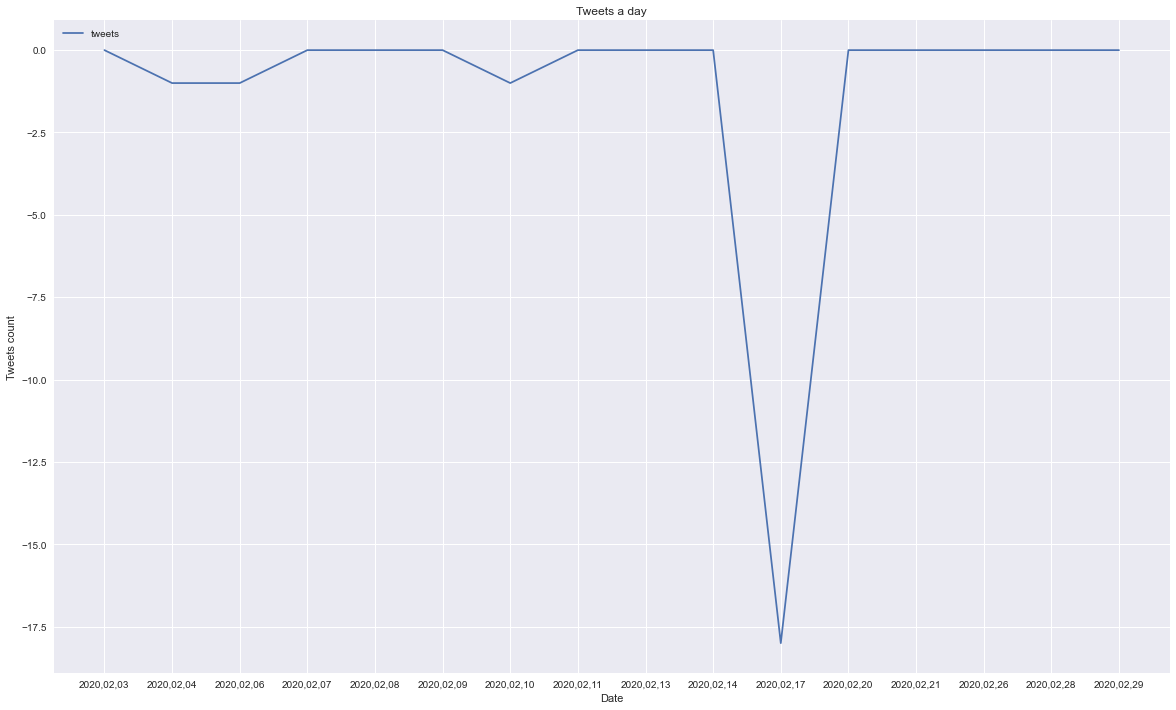

In [300]:
startDate = "2020,02,01"
endDate = "2020,03,01"

startIndex= findClosestDate(startDate)
endIndex= findClosestDate(endDate)
    
plt.rc('font', size=1)
fig, ax = plt.subplots(figsize=(20, 12))

# Specify how our lines should look
ax.plot(dates[startIndex:endIndex], sentimentCounts[startIndex:endIndex], label='tweets')

ax.set_xlabel('Date')
ax.set_ylabel('Tweets count')
ax.set_title('Tweets a day')
ax.grid(True)
ax.legend(loc='upper left');

In [303]:
dateArr = latvenergoTweets.iloc[1]["date"].split(",")
month = dateArr[0]+","+dateArr[1]
print(month)

2017,11


In [304]:
sentimentByMonthList = []

for index, row in latvenergoTweets.iterrows():
    existingDate = 0
    dateArr = row['date'].split(",")
    month = dateArr[0]+","+dateArr[1]
    if (len(sentimentByMonthList)==0):
        if(row['NB_label']==0):
            sentimentByMonthList.append(dateSentimentValues(month, (1 + row['retweetCount']), (1 + row['retweetCount']), 0, 0))
        elif(row['NB_label']==1):
            sentimentByMonthList.append(dateSentimentValues(month, (1 + row['retweetCount']), 0, (1 + row['retweetCount']), 0))
        elif(row['NB_label']==2):
            sentimentByMonthList.append(dateSentimentValues(month, (1 + row['retweetCount']), 0, 0, (1 + row['retweetCount'])))
    else:
        for item in sentimentByMonthList:
            if(item.date == month):
                existingDate = 1
                item.tweetCount += (1 + row['retweetCount'])
                if(row['NB_label']==0):
                    item.neutralCount+=1
                elif(row['NB_label']==1):
                    item.positiveCount+=1
                elif(row['NB_label']==2):
                    item.negativeCount+=1
                break
        if(existingDate==0):
            if(row['NB_label']==0):
                sentimentByMonthList.append(dateSentimentValues(month, (1 + row['retweetCount']), (1 + row['retweetCount']), 0, 0))
            elif(row['NB_label']==1):
                sentimentByMonthList.append(dateSentimentValues(month, (1 + row['retweetCount']), 0, (1 + row['retweetCount']), 0))
            elif(row['NB_label']==2):
                sentimentByMonthList.append(dateSentimentValues(month, (1 + row['retweetCount']), 0, 0, (1 + row['retweetCount'])))
            
print(sentimentByMonthList[:5])

[<__main__.dateSentimentValues object at 0x000001BAABDA6430>, <__main__.dateSentimentValues object at 0x000001BAAA7C2520>, <__main__.dateSentimentValues object at 0x000001BAABDA60D0>, <__main__.dateSentimentValues object at 0x000001BAAA7C23A0>, <__main__.dateSentimentValues object at 0x000001BAAA7C24F0>]


In [306]:
months = []
tweetCounts=[]
neutralCounts = []
positiveCounts=[]
negativeCounts =[]

for item in sentimentByMonthList:
    months.append(item.date)
    tweetCounts.append(item.tweetCount)
    neutralCounts.append(item.neutralCount)
    positiveCounts.append(item.positiveCount) 
    negativeCounts.append(item.negativeCount)

In [312]:
def findClosestMonth(date):
    dateArr = date.split(",")
    d = datetime(int(dateArr[0]),int(dateArr[1]),int(dateArr[2])) #separated by -
    while(d.strftime('%Y,%m') not in months):
        d += timedelta(months=1)

    return months.index(d.strftime('%Y,%m'))

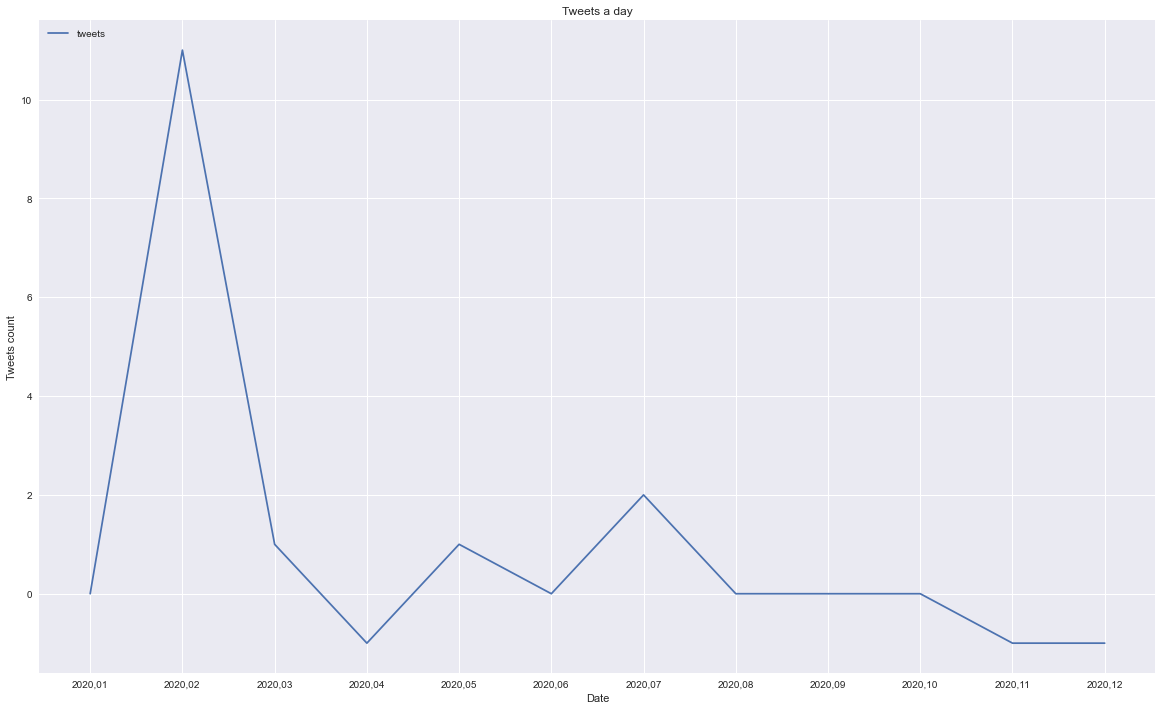

In [313]:
startDate = "2020,01,01"
endDate = "2021,01,01"

startIndex= findClosestMonth(startDate)
endIndex= findClosestMonth(endDate)
    
plt.rc('font', size=1)
fig, ax = plt.subplots(figsize=(20, 12))

# Specify how our lines should look
ax.plot(months[startIndex:endIndex], sentimentCounts[startIndex:endIndex], label='tweets')

ax.set_xlabel('Date')
ax.set_ylabel('Tweets count')
ax.set_title('Tweets a day')
ax.grid(True)
ax.legend(loc='upper left');

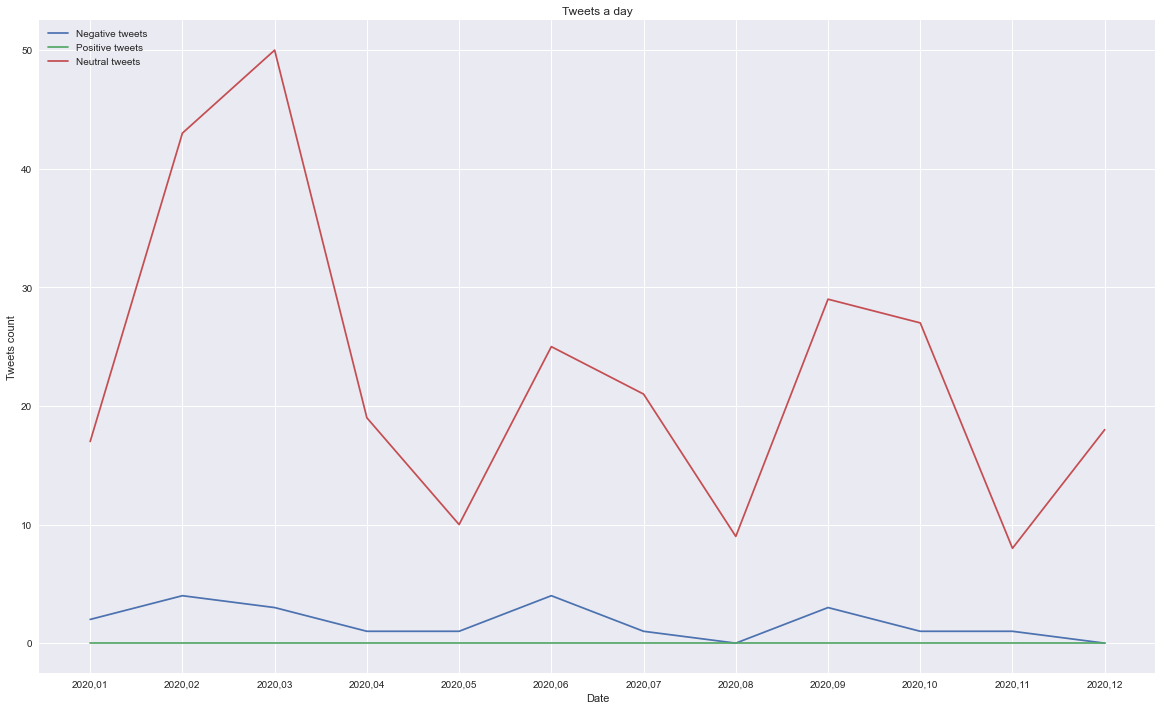

In [314]:
startDate = "2020,01,01"
endDate = "2021,01,01"

startIndex= findClosestMonth(startDate)
endIndex= findClosestMonth(endDate)
    
plt.rc('font', size=1)
fig, ax = plt.subplots(figsize=(20, 12))

# Specify how our lines should look
ax.plot(months[startIndex:endIndex], negativeCounts[startIndex:endIndex], label='Negative tweets')
ax.plot(months[startIndex:endIndex], positiveCounts[startIndex:endIndex], label='Positive tweets')
ax.plot(months[startIndex:endIndex], neutralCounts[startIndex:endIndex], label='Neutral tweets')

ax.set_xlabel('Date')
ax.set_ylabel('Tweets count')
ax.set_title('Tweets a day')
ax.grid(True)
ax.legend(loc='upper left');